In [1]:
import sys
import torch


sys.path.append("..")

from data import get_task, get_dataloader
from helpers import ROOT_DIR
from models.gpt2 import GPT2Editor

torch.cuda.manual_seed(42)


%env CUDA_VISIBLE_DEVICES=2
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
def compute_position_ids(attn_mask: torch.LongTensor) -> torch.Tensor:
    unmasked_len = attn_mask.sum(-1, keepdim=True)
    position_ids = (
        torch.arange(0, attn_mask.shape[-1], device=attn_mask.device)
        .unsqueeze(0)
        .repeat(unmasked_len.shape[0], 1)
    )
    position_ids -= unmasked_len
    position_ids[position_ids < 0] = 0
    return position_ids

In [3]:
attn_mask = torch.cat((torch.zeros(2, 4), torch.ones(2, 4)), dim=-1).to(torch.long)

position_ids = compute_position_ids(attn_mask)
print(attn_mask)
print(position_ids)

tensor([[0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1]])
tensor([[0, 0, 0, 0, 0, 1, 2, 3],
        [0, 0, 0, 0, 0, 1, 2, 3]])


In [4]:
from omegaconf import DictConfig

cfg = DictConfig(
    {
        "model": {"name_or_path": "gpt2", "max_length": 512},
        "task": {
            "name": "wikipedia",
            "followup_char_limit": 500,
            "editor_token_limit": 50,
        },
        "train": {"train_batch_size": 1, "validation_batch_size": 1},
        "data": {
            "test_split": 0.1,
            "val_split": 0.1,
            "n_examples": 1000,
            "train_batch_size": 2,
            "val_batch_size": 2,
        },
        "seed": 42,
    }
)

ds = get_task(cfg, "wikipedia", "train")

dl = get_dataloader(ds, cfg, "train")

Loading dataset from disk:   0%|          | 0/25 [00:00<?, ?it/s]

In [5]:
from transformers import AutoTokenizer

batch = next(iter(dl))

tok = AutoTokenizer.from_pretrained(cfg.model.name_or_path)

In [6]:
from models.gpt2 import GPT2EditorConfig

editor_model = GPT2Editor(GPT2EditorConfig()).cuda()

In [48]:
from helpers import slice_and_move_batch_for_device

batch = next(iter(dl))
out = editor_model(
    **slice_and_move_batch_for_device(batch, 0, 1),
    output_target_hidden_states=True,
    output_edited_hidden_states=True,
    output_edit_vectors=True,
    output_editor_attention=True,
)

stacking dimension is 1


In [49]:
{k: v.shape for k, v in batch.items()}

{'editor_input_ids': torch.Size([1, 512]),
 'editor_attention_mask': torch.Size([1, 512]),
 'target_input_ids': torch.Size([1, 50]),
 'target_attention_mask': torch.Size([1, 50])}

In [50]:
editor_model.target_model.config.eos_token_id

50256

In [51]:
from helpers import visualize_attn_heatmap

In [52]:
batch["target_input_ids"][0][-8:]

tensor([  338, 38412, 11289,   329,  1729,    12, 24046,   492])

Editing target: ['Lewis', 'Ġ(', 'born', 'Ġ1976', ',', 'ĠLondon', ',', 'ĠEngland']
Editor input: ['Na', 'omi', 'ĠK', '.']
Editor preds: [' the', ' the', ' the', ' the', ' the', ' the', ' the', ' the']


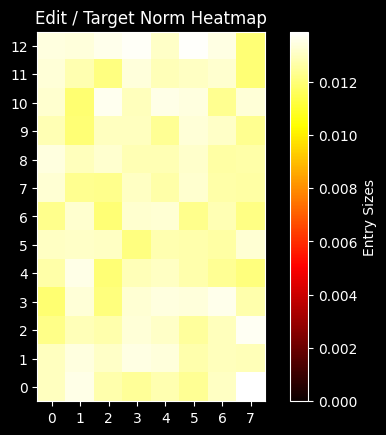

In [53]:
visualize_attn_heatmap(
    result=out,
    batch=batch,
    show_plot=True,
    tokenizer=tok,
    stopping_index=8,
)